In [1]:
import json
import numpy as np
import pandas as pd
from statsmodels.formula.api import ols

%matplotlib inline
import matplotlib as mpl
facecolor = 'white'
mpl.rcParams['figure.facecolor'] = facecolor
from matplotlib import pyplot as plt

# Towards forward selection (testing various models on various regions)

_(very much caring for multiple comparisons)_

The following function `models_eval` returns - _for a given ROI and a GLM formula_ - a table with scores on the _goodness of the fit_, _F-statistic_ (and corresp. p-value) associated to the model and for each variable of the model their corresponding _beta_, _t-value_ and _p-value_.

In [2]:
def models_eval(data, roi_name, formula):
    columns = [roi_name, 'age', 'gender', 'apoe', 'centiloids']
    data = data[columns].rename(columns={roi_name: 'roi'})
    model = ols(formula, data)
    ts = model.fit()
    modelstats = [roi_name, formula, ts.aic, ts.rsquared, ts.fvalue, ts.f_pvalue]
    df = []
    for e in ts.model.exog_names:
        df1 = list(modelstats)
        df1.extend([e, ts.params[e], ts.tvalues[e], ts.pvalues[e]])
        df.append(df1)
        
    columns = ['roi_name',  'model', 'aic', 'R-squared', 'F-stat', 'Prob. (F-stat)', 'variable', 'beta', 't-value', 'p-value']
    return pd.DataFrame(df, columns=columns)

### Iterating over every region of an atlas (previously collected ROI values from FA and MD maps) 

This produces two tables (_one for FA, one for MD_) with, _for every ROI_, an estimation of _every model from a given list_ (incl. _Akaike's criteria_ and _R-squared_), and for _every variable_ of _every model_ their _beta_, _t-value_ and _p-value_.

In [3]:
formulas = ['roi ~ age + 1',
            'roi ~ age + gender + 1',            
            'roi ~ age + gender + apoe + 1', 
            'roi ~ age + gender + centiloids + 1',
            'roi ~ age + gender + apoe + centiloids + 1',
            'roi ~ age + gender + apoe + centiloids + apoe:centiloids + 1']

df = {}
for t in ['FA', 'MD']:
    data = pd.read_excel('/home/grg/amylstaging_ICBM-labels-1mm_TBSS_roivalues_%s.xls'%t, converters={'centiloids': np.float}).set_index('subject')    
    cov = pd.read_excel('/home/grg/SPM/2018/covariates.xlsx').set_index('subject')
    data = data.join(cov)

    df[t] = []
    for i, roi_name in enumerate(set(data.columns).difference(set(cov.columns))):
        for f in formulas:
            df[t].append(models_eval(data, roi_name, f))
    df[t] = pd.concat(df[t])
    df[t].to_excel('/tmp/models_%s.xls'%t)

### Results from fractional anisotropy

In [4]:
fa = df['FA']
fa.head()

,roi_name,model,aic,R-squared,F-stat,Prob. (F-stat),variable,beta,t-value,p-value
0,Cingulum (cingulate gyrus) R,roi ~ age + 1,-530.307230,0.040360,4.710449,0.032091,Intercept,0.483288,17.260687,2.446952e-33
1,Cingulum (cingulate gyrus) R,roi ~ age + 1,-530.307230,0.040360,4.710449,0.032091,age,-0.000973,-2.170357,3.209145e-02
0,Cingulum (cingulate gyrus) R,roi ~ age + gender + 1,-529.146759,0.047401,2.761675,0.067531,Intercept,0.487621,17.153380,5.418162e-33
1,Cingulum (cingulate gyrus) R,roi ~ age + gender + 1,-529.146759,0.047401,2.761675,0.067531,age,-0.000952,-2.118494,3.636403e-02
2,Cingulum (cingulate gyrus) R,roi ~ age + gender + 1,-529.146759,0.047401,2.761675,0.067531,gender,-0.004130,-0.905789,3.670096e-01


### Results from mean diffusivity

In [5]:
md = df['MD']
md.head()

,roi_name,model,aic,R-squared,F-stat,Prob. (F-stat),variable,beta,t-value,p-value
0,Cingulum (cingulate gyrus) R,roi ~ age + 1,-2003.836030,0.100898,12.568672,0.000574,Intercept,0.000581,13.301494,8.556989e-25
1,Cingulum (cingulate gyrus) R,roi ~ age + 1,-2003.836030,0.100898,12.568672,0.000574,age,0.000002,3.545232,5.736678e-04
0,Cingulum (cingulate gyrus) R,roi ~ age + gender + 1,-2003.140803,0.111129,6.938787,0.001447,Intercept,0.000573,12.937935,6.658634e-24
1,Cingulum (cingulate gyrus) R,roi ~ age + gender + 1,-2003.140803,0.111129,6.938787,0.001447,age,0.000002,3.485931,7.034682e-04
2,Cingulum (cingulate gyrus) R,roi ~ age + gender + 1,-2003.140803,0.111129,6.938787,0.001447,gender,0.000008,1.130370,2.607571e-01


## Looking at the results

What are the general trends of FA and MD _with increasing age_ across all the tested models?

(array([ 6.,  0.,  0.,  0., 53., 90., 73., 38., 18., 10.]),
 array([-3.44281156e-03, -3.02379490e-03, -2.60477824e-03, -2.18576158e-03,
        -1.76674492e-03, -1.34772825e-03, -9.28711595e-04, -5.09694934e-04,
        -9.06782738e-05,  3.28338386e-04,  7.47355047e-04]),
 <a list of 10 Patch objects>)

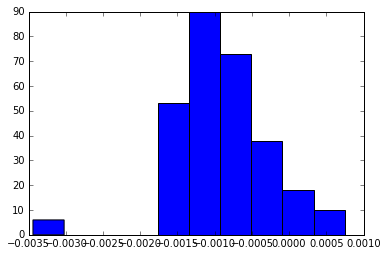

In [6]:
betas_age_fa = fa[fa['variable'] == 'age']['beta']
plt.hist(betas_age_fa)

(array([ 94., 133.,  39.,  11.,   3.,   2.,   0.,   0.,   3.,   3.]),
 array([-5.66579070e-07,  1.29760538e-06,  3.16178984e-06,  5.02597429e-06,
         6.89015875e-06,  8.75434320e-06,  1.06185277e-05,  1.24827121e-05,
         1.43468966e-05,  1.62110810e-05,  1.80752655e-05]),
 <a list of 10 Patch objects>)

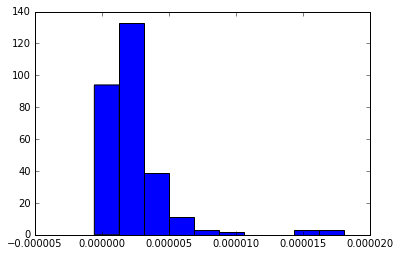

In [7]:
betas_age_md = md[md['variable'] == 'age']['beta']
plt.hist(betas_age_md)

What are the _regions_ where FA and MD have _significant decreases/increases_ as age increases?

In [8]:
sign_fa = fa[fa['p-value']<0.001]
sign_fa[sign_fa['variable'] == 'age']

,roi_name,model,aic,R-squared,F-stat,Prob. (F-stat),variable,beta,t-value,p-value
1,Fornix (column and body of fornix),roi ~ age + 1,-367.154597,0.102778,12.829771,0.000506,age,-0.003284,-3.581867,0.000506
1,Fornix (column and body of fornix),roi ~ age + gender + 1,-368.490341,0.128651,8.194361,0.000479,age,-0.003198,-3.518922,0.000629
1,Fornix (column and body of fornix),roi ~ age + gender + centiloids + 1,-367.235109,0.134325,5.689505,0.001168,age,-0.003443,-3.606851,0.000468
1,Fornix (cres) / Stria terminalis (can not be r...,roi ~ age + 1,-506.943696,0.098651,12.258248,0.000666,age,-0.001739,-3.501178,0.000666
1,Fornix (cres) / Stria terminalis (can not be r...,roi ~ age + gender + 1,-507.066431,0.115280,7.231686,0.001116,age,-0.001702,-3.438108,0.000826
1,Fornix (cres) / Stria terminalis (can not be r...,roi ~ age + gender + centiloids + 1,-505.243216,0.116651,4.842010,0.003336,age,-0.001767,-3.390146,0.000971
1,External capsule L,roi ~ age + 1,-589.432728,0.105246,13.174008,0.000429,age,-0.001255,-3.629602,0.000429
1,External capsule L,roi ~ age + gender + 1,-595.866932,0.169054,11.291326,0.000034,age,-0.001204,-3.592374,0.000490
1,External capsule L,roi ~ age + gender + centiloids + 1,-593.954776,0.169694,7.493750,0.000131,age,-0.001235,-3.498505,0.000676


In [9]:
sign_md = md[md['p-value']<0.001]
sign_md[sign_md['variable'] == 'age']

,roi_name,model,aic,R-squared,F-stat,Prob. (F-stat),variable,beta,t-value,p-value
1,Cingulum (cingulate gyrus) R,roi ~ age + 1,-2003.836030,0.100898,12.568672,0.000574,age,0.000002,3.545232,0.000574
1,Cingulum (cingulate gyrus) R,roi ~ age + gender + 1,-2003.140803,0.111129,6.938787,0.001447,age,0.000002,3.485931,0.000703
1,Cingulum (cingulate gyrus) R,roi ~ age + gender + apoe + 1,-2002.013308,0.117906,4.901110,0.003099,age,0.000003,3.555491,0.000558
1,Cingulum (cingulate gyrus) R,roi ~ age + gender + apoe + centiloids + apoe:...,-2000.440224,0.136487,3.414090,0.006661,age,0.000003,3.382921,0.001000
1,Anterior limb of internal capsule L,roi ~ age + 1,-1984.184635,0.124358,15.906209,0.000119,age,0.000003,3.988259,0.000119
1,Anterior limb of internal capsule L,roi ~ age + gender + 1,-1992.104438,0.197332,13.644410,0.000005,age,0.000003,3.975881,0.000125
1,Anterior limb of internal capsule L,roi ~ age + gender + apoe + 1,-1992.582411,0.214591,10.018145,0.000007,age,0.000003,4.287355,0.000039
1,Anterior limb of internal capsule L,roi ~ age + gender + centiloids + 1,-1990.501190,0.200121,9.173585,0.000018,age,0.000003,3.592840,0.000491
1,Anterior limb of internal capsule L,roi ~ age + gender + apoe + centiloids + 1,-1990.660711,0.215130,7.469142,0.000024,age,0.000003,3.872591,0.000184
1,Anterior limb of internal capsule L,roi ~ age + gender + apoe + centiloids + apoe:...,-1989.105227,0.218185,6.028013,0.000059,age,0.000003,3.891245,0.000173
